In [1]:
import os
import glob
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pickle
import sqlite3
import gc
from datetime import datetime
pd.set_option('display.max_rows', 500)

### Connect to DB

In [ ]:
db_path = "/home/shein/Documents/grad_school/research/ClusterMonitoring/data/all_data.db"

In [ ]:
con = sqlite3.connect(db_path)
cur = con.cursor()

## Query Metrics

### GPU Metrics

In [ ]:
smi_util_q = """SELECT timestamp_ms, hostname, device_id, value FROM Data 
    WHERE field_id = 203 and timestamp_ms < 1709917200000"""
sm_active_util_q = """SELECT timestamp_ms, hostname, device_id, value FROM Data 
    WHERE field_id = 1002 and timestamp_ms < 1709917200000"""
occupancy_util_q = """SELECT timestamp_ms, hostname, device_id, value FROM Data 
    WHERE field_id = 1003 and timestamp_ms < 1709917200000"""
tensor_util_q = """SELECT timestamp_ms, hostname, device_id, value FROM Data 
    WHERE field_id = 1004 and timestamp_ms < 1709917200000"""
memory_bandwidth_q = """SELECT timestamp_ms, hostname, device_id, value FROM Data 
    WHERE field_id = 1005 and timestamp_ms < 1709917200000"""
gpu_mem_q = """SELECT timestamp_ms, hostname, device_id, value FROM Data 
    WHERE field_id = 254 and timestamp_ms < 1709917200000"""

### CPU Metrics

In [ ]:
cpu_util_q = """SELECT timestamp_ms, hostname, device_id, value FROM Data 
    WHERE field_id = 1 and timestamp_ms < 1709917200000"""
cpu_mem_q = """SELECT timestamp_ms, hostname, device_id, value FROM Data 
    WHERE field_id = 0 and timestamp_ms < 1709917200000"""

### Fetching & dumping data in python format for later use...

In [ ]:
result = cur.execute(smi_util_q)
all_smi_util = result.fetchall()

In [ ]:
pickle.dump(all_smi_util, open("all_smi_util.pkl", "wb"))

In [ ]:
result = cur.execute(sm_active_util_q)
all_sm_active_util = result.fetchall()

In [ ]:
pickle.dump(all_sm_active_util, open("all_sm_active_util.pkl", "wb"))

In [ ]:
result = cur.execute(occupancy_util_q)
all_occupancy_util = result.fetchall()

In [ ]:
pickle.dump(all_occupancy_util, open("all_occupancy_util.pkl", "wb"))

In [ ]:
result = cur.execute(tensor_util_q)
all_tensor_core_util = result.fetchall()

In [ ]:
pickle.dump(all_tensor_core_util, open("all_tensor_core_util.pkl", "wb"))

In [ ]:
result = cur.execute(memory_bandwidth_q)
all_mem_band_util = result.fetchall()

In [ ]:
pickle.dump(all_mem_band_util, open("all_mem_band_util.pkl", "wb"))

In [ ]:
result = cur.execute(gpu_mem_q)
all_gpu_mem = result.fetchall()

In [ ]:
pickle.dump(all_gpu_mem, open("all_gpu_mem.pkl", "wb"))

#### Retrieving CPU Util and Mem

In [ ]:
result = cur.execute(cpu_util_q)
all_cpu_util = result.fetchall()

In [ ]:
pickle.dump(all_cpu_util, open("all_cpu_util.pkl", "wb"))

In [ ]:
result = cur.execute(cpu_mem_q)
all_cpu_mem = result.fetchall()

In [ ]:
pickle.dump(all_cpu_mem, open("all_cpu_mem.pkl", "wb"))

### Loading previously queried data

In [ ]:
all_smi_util = pickle.load(open("all_smi_util.pkl", "rb"))

In [ ]:
all_sm_active_util = pickle.load(open("all_sm_active_util.pkl", "rb"))

In [ ]:
all_tensor_core_util = pickle.load(open("all_tensor_core_util.pkl", "rb"))

In [ ]:
all_mem_band_util = pickle.load(open("all_mem_band_util.pkl", "rb"))

In [ ]:
all_occupancy_util = pickle.load(open("all_occupancy_util.pkl", "rb"))

In [ ]:
all_gpu_mem = pickle.load(open("all_gpu_mem.pkl", "rb"))

In [5]:
all_cpu_mem = pickle.load(open("all_cpu_mem.pkl", "rb"))

In [6]:
all_cpu_util = pickle.load(open("all_cpu_util.pkl", "rb"))

### Isolating Non-Idle Times

In [ ]:
non_idle_smi = {}
workday_non_idle_smi = {}
for r in all_smi_util:
    if r[3] != 0:
        non_idle_smi[(r[0], r[1], r[2])] = r[3]
        dt = datetime.fromtimestamp(r[0] / 1e3)
        if (dt.weekday() < 5) and (dt.hour > 8 and dt.hour < 22):
            workday_non_idle_smi[(r[0], r[1], r[2])] = r[3]

In [ ]:
non_idle_sm_active = {}
workday_non_idle_sm_active = {}
non_idle_metric_diffs = {}
workday_non_idle_metric_diffs = {}
for r in all_sm_active_util:
    if (r[0], r[1], r[2]) in non_idle_smi:
        non_idle_sm_active[(r[0], r[1], r[2])] = r[3]
        non_idle_metric_diffs[(r[0], r[1], r[2])] = non_idle_smi[(r[0], r[1], r[2])] - r[3]
    if (r[0], r[1], r[2]) in workday_non_idle_smi:
        workday_non_idle_sm_active[(r[0], r[1], r[2])] = r[3]
        workday_non_idle_metric_diffs[(r[0], r[1], r[2])] = non_idle_smi[(r[0], r[1], r[2])] - r[3]

In [7]:
def filter_node_non_idle(cpu_records, non_idle_smi):
    non_idle_node = {}
    ## hardcoding 4 devices
    n_devices = 4
    for r in cpu_records:
        ## only need one of the devices to be non-idle to count
        any_dev_active = False
        for k in range(n_devices):
            if (r[0], r[1], k) in non_idle_smi:
                any_dev_active = True
                break
        if any_dev_active:
            non_idle_node[(r[0], r[1], r[2])] = r[3]
    return non_idle_node

## Dumping for later anaylysis...

### Extracting samples only when SMI > 0 (non-idle)

In [ ]:
pickle.dump(non_idle_smi, open("non_idle_smi.pkl", "wb"))
pickle.dump(non_idle_sm_active, open("non_idle_sm_active.pkl", "wb"))
pickle.dump(non_idle_metric_diffs, open("non_idle_metric_diffs.pkl", "wb"))

### Further filtering for weekdays between 8am and 10pm

In [ ]:
pickle.dump(workday_non_idle_smi, open("workday_non_idle_smi.pkl", "wb"))
pickle.dump(workday_non_idle_sm_active, open("workday_non_idle_sm_active.pkl", "wb"))
pickle.dump(workday_non_idle_metric_diffs, open("workday_non_idle_metric_diffs.pkl", "wb"))

### Loading

In [3]:
workday_smi = pickle.load(open("workday_non_idle_smi.pkl", "rb"))
workday_smi_vals = np.array([v for _, v in workday_smi.items()])

In [4]:
smi = pickle.load(open("non_idle_smi.pkl", "rb"))
smi_vals = np.array([v for _, v in smi.items()])

In [ ]:
workday_sm_active = pickle.load(open("workday_non_idle_sm_active.pkl", "rb"))
workday_sm_active_vals = np.array([v for _, v in workday_sm_active.items()])

In [ ]:
sm_active = pickle.load(open("non_idle_sm_active.pkl", "rb"))
sm_active_vals = np.array([v for _, v in sm_active.items()])

In [ ]:
workday_metric_diffs = pickle.load(open("workday_non_idle_metric_diffs.pkl", "rb"))
workday_metric_diffs_vals = np.array([v for _, v in workday_metric_diffs.items()])

In [ ]:
metric_diffs = pickle.load(open("non_idle_metric_diffs.pkl", "rb"))
metric_diffs_vals = np.array([v for _, v in metric_diffs.items()])

#### Doing more workday filtering on previously queried results

In [ ]:
def workday_filtering(vals, workday_smi):
    workday = {}
    for r in vals:
        if (r[0], r[1], r[2]) in workday_smi:
            workday[(r[0], r[1], r[2])] = r[3]
    return workday

In [ ]:
workday_tensor_core = workday_filtering(all_tensor_core_util, workday_smi)
workday_occupancy = workday_filtering(all_occupancy_util, workday_smi)
workday_mem_band = workday_filtering(all_mem_band_util, workday_smi)

In [ ]:
workday_gpu_mem = workday_filtering(all_gpu_mem, workday_smi)

In [ ]:
pickle.dump(workday_tensor_core, open("workday_tensor_core_util.pkl", "wb"))
pickle.dump(workday_occupancy, open("workday_occupancy_util.pkl", "wb"))
pickle.dump(workday_mem_band, open("workday_mem_band_util.pkl", "wb"))

In [ ]:
pickle.dump(workday_gpu_mem, open("workday_gpu_mem.pkl", "wb"))

In [ ]:
workday_tensor_core_vals = np.array([v for _, v in workday_tensor_core.items()])

In [ ]:
workday_occupancy_vals = np.array([v for _, v in workday_occupancy.items()])
workday_mem_band_vals = np.array([v for _, v in workday_mem_band.items()])

In [ ]:
workday_gpu_mem_vals = np.array([v for _, v in workday_gpu_mem.items()])

## Retrieving Filtered CPU Metrics
- Here we count "non-idle" meaning at least one device has non-zero SMI at the record timestamp

In [8]:
workday_cpu_util = filter_node_non_idle(all_cpu_util, workday_smi)
cpu_util = filter_node_non_idle(all_cpu_util, smi)

In [24]:
unique_hosts = set([k[1] for k, _ in workday_cpu_util.items()])

In [26]:
mem_capacities = {"della-l08g7": 1024000, "della-l09g1": 1024000, "della-l09g2": 1024000, "della-l09g3": 1024000}

In [13]:
workday_cpu_util_vals = np.array([v for _, v in workday_cpu_util.items()])

In [9]:
pickle.dump(workday_cpu_util, open("workday_cpu_util.pkl", "wb"))
pickle.dump(cpu_util, open("cpu_util.pkl", "wb"))

In [10]:
workday_cpu_mem = filter_node_non_idle(all_cpu_mem, workday_smi)
cpu_mem = filter_node_non_idle(all_cpu_mem, smi)

In [39]:
## these are TB nodes
## numerator in free MB so multiply by 2^20 to cancel
## 1 - free to get util
## multiply by 100 to stay consisent
workday_cpu_mem_vals = 100 * (1 - (np.minimum(1, np.array([v for _, v in workday_cpu_mem.items()]) * (1 << 20) / (1 << 40))))

In [42]:
max(workday_cpu_mem_vals)

99.02181625366211

In [11]:
pickle.dump(workday_cpu_mem, open("workday_cpu_mem.pkl", "wb"))
pickle.dump(cpu_mem, open("cpu_mem.pkl", "wb"))

# Plotting Histograms

In [19]:
def create_hist(vals_list, names, colors, title, x_title = "Utilization %", y_title = "Density", y_range=[0,1], bins = np.arange(0, 101, 5)):
    bin_names = ["[" + str(bins[i]) + ", " + str(bins[i + 1]) + ")" for i in range(len(bins) - 1)]
    bin_names[-1] = bin_names[-1][:-1] + "]"
    fig = go.Figure()
    for i in range(len(vals_list)):
        vals = vals_list[i]
        name, color = names[i], colors[i]
        ## get the distribution
        counts, _ = np.histogram(vals, bins)
        density = counts / sum(counts)
        ## plot the histogram
        fig.add_trace(go.Bar(x=bin_names,
                             y=density,
                             name=name,
                             text=density,
                             textposition="outside",
                             texttemplate="%{text:.2f}",
                             marker={"color":color}))

    fig.update_layout(
            xaxis = {"title": x_title},
            yaxis = {"title": y_title, "range": y_range},
            title = title
    )
    return fig

## GPU Plots

In [ ]:
vals_list = [workday_metric_diffs_vals]
names = ["Raw Metric Difference"]
colors = ["violet"]
title = "Difference betewen Utilization Metrics at Non-Idle times. Feb 15 - Mar 8 (8am - 10pm, weekdays). 44 million records (from 4 nodes x 4 GPUs)"
x_title = "Nvidia-SMI % minus DCGM's SM Active %"
y_range = [0, .3]
workday_metric_diffs_fig = create_hist(vals_list, names, colors, title, x_title=x_title, y_range=y_range)
workday_metric_diffs_fig.show()

In [ ]:
vals_list = [workday_smi_vals, workday_sm_active_vals]
names = ["Nvidia-SMI", "SM Active"]
colors = ["blue", "red"]
title = "Utilization Metrics at Non-Idle times. Feb 15 - Mar 8 (8am - 10pm, weekdays). 44 million records (from 4 nodes x 4 GPUs)"
y_range = [0, .65]
workday_utils_fig = create_hist(vals_list, names, colors, title, y_range=y_range)
workday_utils_fig.show()

In [ ]:
vals_list = [workday_tensor_core_vals]
names = ["Tensor Core Active"]
colors = ["green"]
title = "Tensor Core Active % at Non-Idle times. Feb 15 - Mar 8 (8am - 10pm, weekdays). 44 million records (from 4 nodes x 4 GPUs)"
y_range = [0, .3]
workday_tensor_core_fig = create_hist(vals_list, names, colors, title, y_range=y_range)
workday_tensor_core_fig.show()

In [ ]:
vals_list = [workday_mem_band_vals]
names = ["Memory Bandwidth"]
colors = ["darkslategray"]
y_range = [0, .3]
title = "Memory Bandwidth Utilizaiton at Non-Idle times. Feb 15 - Mar 8 (8am - 10pm, weekdays). 44 million records (from 4 nodes x 4 GPUs)"
workday_mem_band_fig = create_hist(vals_list, names, colors, title, y_range=y_range)
workday_mem_band_fig.show()

In [ ]:
vals_list = [workday_occupancy_vals]
names = ["Occupancy"]
colors = ["darkorange"]
title = "Occupancy at Non-Idle times. Feb 15 - Mar 8 (8am - 10pm, weekdays). 44 million records (from 4 nodes x 4 GPUs)"
y_range = [0, .3]
workday_occupancy_fig = create_hist(vals_list, names, colors, title, y_range=y_range)
workday_occupancy_fig.show()

In [ ]:
vals_list = [workday_gpu_mem_vals]
names = ["GPU Memory"]
colors = ["black"]
title = "GPU Memory at Non-Idle times. Feb 15 - Mar 8 (8am - 10pm, weekdays). 44 million records (from 4 nodes x 4 GPUs)"
y_range = [0, .3]
workday_gpu_mem_fig = create_hist(vals_list, names, colors, title, y_range=y_range)
workday_gpu_mem_fig.show()

In [17]:
print(len(workday_cpu_mem_vals))

15149821


## CPU Plots

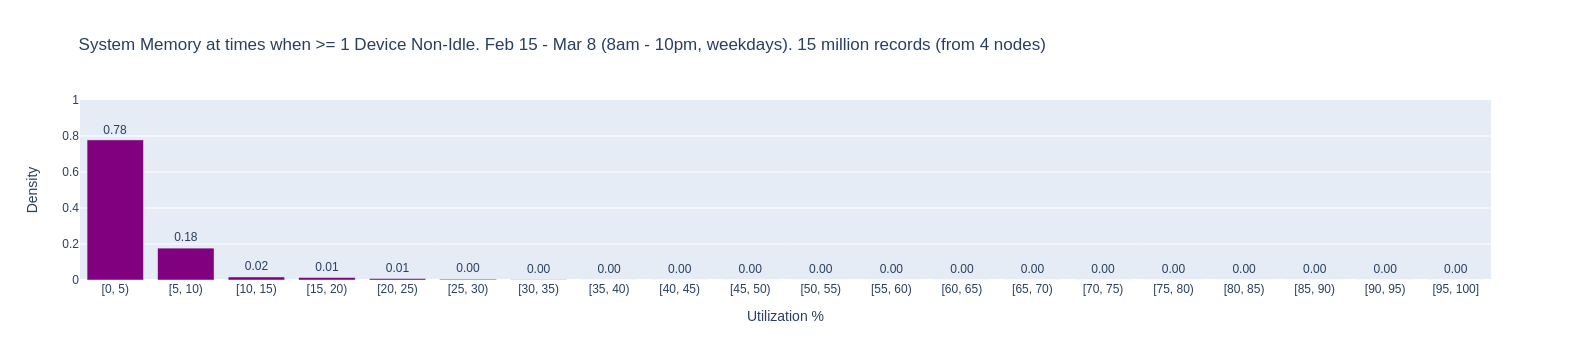

In [54]:
vals_list = [workday_cpu_mem_vals]
names = ["System Memory"]
colors = ["purple"]
title = "System Memory at times when >= 1 Device Non-Idle. Feb 15 - Mar 8 (8am - 10pm, weekdays). 15 million records (from 4 nodes)"
y_range = [0, 1]
workday_cpu_mem_fig = create_hist(vals_list, names, colors, title, y_range=y_range)
workday_cpu_mem_fig.show()

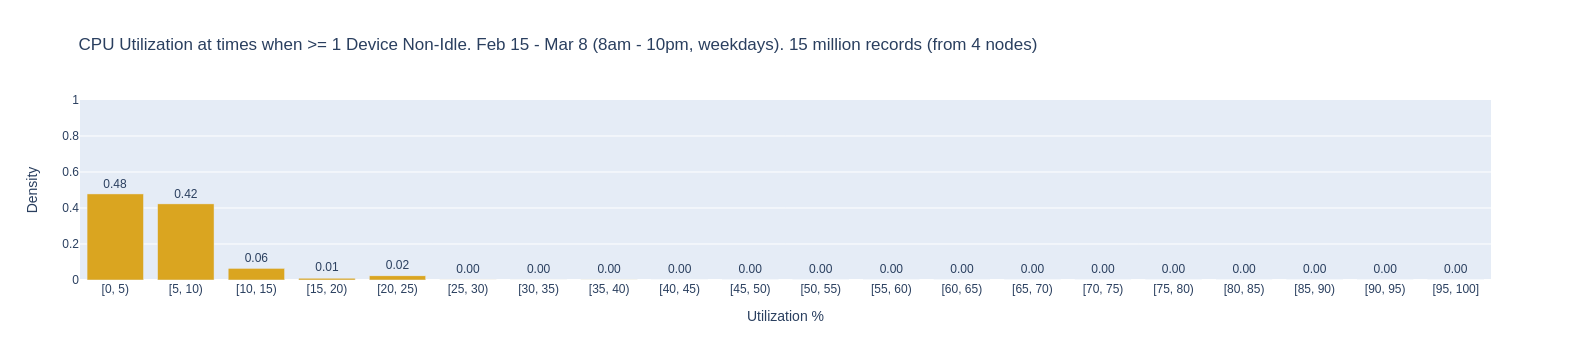

In [55]:
vals_list = [workday_cpu_util_vals]
names = ["CPU Util"]
colors = ["goldenrod"]
title = "CPU Utilization at times when >= 1 Device Non-Idle. Feb 15 - Mar 8 (8am - 10pm, weekdays). 15 million records (from 4 nodes)"
y_range = [0, 1]
workday_cpu_mem_fig = create_hist(vals_list, names, colors, title, y_range=y_range)
workday_cpu_mem_fig.show()

In [22]:
workday_cpu_mem_vals

array([1024415, 1024415, 1024415, ..., 1054746, 1054746, 1054746])

In [ ]:
vals_list = [workday_cpu_util_vals]
names = ["CPU Utilization"]
colors = ["darkred"]
title = "CPU Utilization at times when >= 1 Device Non-Idle. Feb 15 - Mar 8 (8am - 10pm, weekdays). 15 million records (from 4 nodes)"
y_range = [0, .3]
workday_cpu_util_fig = create_hist(vals_list, names, colors, title, y_range=y_range)
workday_cpu_util_fig.show()

## Plotting Time Series
#### Need to make sure not plotting too many points!

In [ ]:
gpu_figs = {}
for gpu_id, gpu_util_slice in gpu_slices.items():
    gpu_smi = gpu_util_slice.loc[gpu_util_slice["field_id"] == 203, :]
    gpu_sm_active = gpu_util_slice.loc[gpu_util_slice["field_id"] == 1002, :]
    gpu_sm_active_vals = (gpu_sm_active["value"] * 100).astype(np.int32)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=gpu_smi["ms_from_start"], y=gpu_smi["value"].astype(np.int32),
                    mode='lines+markers',
                    name='nvidia-smi util',
                    marker=dict(color="blue")))
    fig.add_trace(go.Scatter(x=gpu_sm_active["ms_from_start"], y=gpu_sm_active_vals,
                    mode='lines+markers',
                    name='sm active',
                    marker=dict(color="red")))
                  
    fig.update_layout(
        xaxis = dict(
        title = "Time (ms)"
        ),
        yaxis = dict(
            title = "Utilization %",
        ),
        title = "GPU ID: " + gpu_id
    )
    gpu_figs[gpu_id] = fig